In [1]:
import numpy as np
import dynet_config
dynet_config.set(
    mem=2048,          # can probably get away with 1024
    autobatch=True,    # utilize autobatching
    random_seed=1978   # simply for reproducibility here
)
import dynet as dy
from os import path
import random

# `dyNet` example: `spam` v. `ham`

In [2]:
dy.__version__

2.0

## import features

In [3]:
import sys
sys.path.append("..")
import utils as u

In [4]:
# change this string to match the path on your computer
path_to_root = "/Users/mcapizzi/Github/dynet_tutorial/"

In [5]:
train_docs, train_labels, dev_docs, dev_labels, test_docs, test_labels = u.import_smsspam(path_to_root)

loading training data; 1 == spam, 2 == ham
loading dev data; 1 == spam, 2 == ham
loading testing data; 1 == spam, 2 == ham


In [6]:
len(train_docs), len(train_labels)

(3345, 3345)

In [7]:
len(dev_docs), len(dev_labels)

(1115, 1115)

In [8]:
len(test_docs), len(test_labels)

(1114, 1114)

The labels are either `1` or `0` where `1=Spam` and `0=Ham`

In [9]:
test_labels[0:20]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]

Right now, the "features" are still just raw documents

In [10]:
for i in range(3):
    print(train_docs[i])

['Go', 'until', 'jurong', 'point,', 'crazy..', 'Available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet...', 'Cine', 'there', 'got', 'amore', 'wat...']
['Ok', 'lar...', 'Joking', 'wif', 'u', 'oni...']
['Free', 'entry', 'in', '2', 'a', 'wkly', 'comp', 'to', 'win', 'FA', 'Cup', 'final', 'tkts', '21st', 'May', '2005.', 'Text', 'FA', 'to', '87121', 'to', 'receive', 'entry', 'question(std', 'txt', "rate)T&C's", 'apply', "08452810075over18's"]


## build architecture
all images borrowed from here: http://u.cs.biu.ac.il/~yogo/nnlp.pdf (now a book!)

![goldberg_nn](images/goldberg_ff.png)

![goldberg_ff_math](images/goldberg_ff_math.png)

### initialize empty model

See http://dynet.readthedocs.io/en/latest/python_ref.html#parametercollection

The first thing to be done is initialize the `ParameterCollection()` which will house all the parameters that will be updated during training.

In [11]:
feed_forward_model = dy.ParameterCollection()   # used to be called dy.Model()
feed_forward_model

### embeddings

We are going to turn each document into an *average* of the embeddings for each word.  In order to do that, we have two choices:
 1. ...randomly initialize the word embeddings.
 2. ...load some pretrained word embeddings.  

#### randomly initialized embeddings

The `embedding matrix` will be of size `size_vocabulary x embedding_dim` where the $i^{th}$ row of the matrix is the embedding vector for the $i^{th}$ indexed word.

So first we'll need to build the `word-2-index` lookup table of all the words in the vocabulary.

In [12]:
w2i_random = u.build_w2i_lookup(train_docs)
w2i_random["the"]

160

#### pretrained embeddings
The embeddings we'll use are from this paper: https://levyomer.files.wordpress.com/2014/04/dependency-based-word-embeddings-acl-2014.pdf <br>
And can be downloaded here: https://levyomer.wordpress.com/2014/04/25/dependency-based-word-embeddings/

In *most* cases, these vectors are ordered by frequency, so we can safely take the `top n` words to save some computation. 

In [13]:
emb_matrix_pretrained, w2i_pretrained = u.load_pretrained_embeddings(
    path.join(path_to_root, "pretrained_embeddings.txt"), 
    take=5000
)

We now have (1) an `embedding matrix` of size `num_words x embedding_dim` and (2) a `word-2-index` lookup table.  

In [14]:
print("embedding matrix shape: {}".format(emb_matrix_pretrained.shape))
print("index for '{}': {}".format("the", w2i_pretrained["the"]))

embedding matrix shape: (5001, 300)
index for 'the': 1


Now let's build the actual `dyNet` parameters for the embeddings.  These *will* be updated during training, which will lead to "catered" embeddings specialized for our `spam/ham` task.

In [15]:
###### CHOOSE HERE which approach you want to use. ######
embedding_approach, embedding_dim = "pretrained", emb_matrix_pretrained.shape[1]
# embedding_approach, embedding_dim = "random", 300

In [16]:
if embedding_approach == "pretrained":
    embedding_parameters = feed_forward_model.lookup_parameters_from_numpy(emb_matrix_pretrained)
    w2i = w2i_pretrained    # ensure we use the correct lookup table
elif embedding_approach == "random":
    embedding_parameters = feed_forward_model.add_lookup_parameters((len(w2i_random)+1, embedding_dim))
    w2i = w2i_random        # ensure we use the correct lookup table
else:
    raise Exception("you chose poorly...")
dy.parameter(embedding_parameters).npvalue().shape

(300, 5001)

### input size

To generate our input, we'll be taking the average word embedding for all words in the document.  So it's size will be equal to the dimension of our word embeddings.

In [17]:
input_size = embedding_dim
input_size

300

### hidden dimension

You still have a decision on what size you want the `hidden` layer to be.

![goldberg_math_simple](images/goldberg_ff_math_simple.png)

In [18]:
################
# HYPERPARAMETER
################
# size of hidden layer
hidden_size = 200

#### paramater `initializer`
See http://dynet.readthedocs.io/en/latest/python_ref.html#parameters-initializers

Next we need to "initialize" the parameter values.  `GlorotInitializer` is a pretty standard approach *however* the `gain` parameter depends on the type of `activation` being used.

In [19]:
################
# HYPERPARAMETER
################
initializer = dy.GlorotInitializer(gain=4.0)

You'll notice that the objects are `_dynet.Parameters` and *not* `expressions` until you "wrap" them with `dy.parameter()`

In [20]:
# W_1 (input x hidden) as a Parameters object
pW_1 = feed_forward_model.add_parameters(
    (input_size, hidden_size),
    init=initializer
)
type(pW_1), type(dy.parameter(pW_1))

(_dynet.Parameters, _dynet.Expression)

In [21]:
# check the shape of the Expression
dy.parameter(pW_1).npvalue().shape

(300, 200)

In [22]:
# b_1 (1 x hidden) as a Parameters object
pb_1 = feed_forward_model.add_parameters(
    (1, hidden_size),
    init=initializer
)
# check the shape
dy.parameter(pb_1).npvalue().shape

(1, 200)

In [23]:
# W_2 (hidden x output) as a Parameters object
pW_2 = feed_forward_model.add_parameters(
    (hidden_size, 1),
    init=initializer
)
# check the shape
dy.parameter(pW_2).npvalue().shape

(200, 1)

In [24]:
# b_2 (1 x output) as a Paramters object
pb_2 = feed_forward_model.add_parameters(
    (1, 1),
    init=initializer
)
# check the shape
dy.parameter(pb_2).npvalue().shape

(1, 1)

### converting words to indexes

In order to access the word embedding for a given word, we need to know its `index` from our `word2index` lookup table.

In [25]:
def words2indexes(seq_of_words, w2i_lookup):
    """
    This function converts our document into a sequence of indexes that correspond to the rows in our embedding matrix
    :param seq_of_words: the document as a <list> of words
    :param w2i_lookup: the lookup table of {word:index} that we built earlier
    """
    seq_of_idxs = []
    for w in seq_of_words:
        w = w.lower()            # lowercase
        i = w2i_lookup.get(w, 0) # we use the .get() method to allow for default return value if the word is not found
                                 # we've reserved the 0th row of embedding matrix for out-of-vocabulary words
        seq_of_idxs.append(i)
    return seq_of_idxs

In [26]:
sample_idxs = words2indexes(["I", "like", "armadillos"], w2i)
sample_idxs

[29, 330, 0]

In [27]:
def get_average_embedding(seq_of_idxs):
    """
    This function will take a sequence of indexes (which represents each of the words in our document) 
    and will return an average embedding to now represent the document
    :param seq_of_idxs: output of words2indexes()
    """
    seq_of_embeddings = [embedding_parameters[i] for i in seq_of_idxs]   # embedding_parameters can be used like <dict>
    average_embedding = dy.average(seq_of_embeddings)
    return dy.reshape(average_embedding, (1,300))      # need to reshape to an explicit 1 x ??? vector

In [28]:
sample_average_embedding = get_average_embedding(sample_idxs)
sample_average_embedding.npvalue()

array([[  2.90775904e-03,   5.09412680e-03,   1.79931540e-02,
         -3.60248461e-02,  -2.73635816e-02,   9.58728045e-03,
         -2.32764576e-02,  -3.17369145e-03,   2.68593710e-02,
         -6.22892985e-03,   2.44046245e-02,   4.14363248e-03,
          7.23031815e-03,   3.16809834e-04,  -1.54533647e-02,
         -2.47859117e-02,  -5.86350635e-02,  -5.79605959e-02,
         -1.00360718e-02,   1.51551692e-02,  -3.78740542e-02,
         -3.99237759e-02,   1.31739099e-02,  -4.71997671e-02,
          6.86733797e-02,   5.29726222e-02,  -3.93233495e-03,
          1.07182777e-02,   7.38620944e-03,  -2.43036561e-02,
          1.10193091e-02,   8.02149996e-03,   6.36167591e-03,
         -1.68125313e-02,  -2.90750396e-02,  -2.93785091e-02,
          9.91539657e-03,   7.05230189e-03,  -1.45967472e-02,
         -2.46045343e-03,  -1.30066145e-02,   2.21646810e-03,
          1.33913625e-02,  -3.73893864e-02,  -8.10857303e-03,
         -8.24909098e-03,   6.19452400e-03,   1.01481741e-02,
        

### forward operations
![goldberg_math_simple](images/goldberg_ff_math_simple.png)

The only real choice is the type of `activation`.  See here for your choices: http://dynet.readthedocs.io/en/latest/operations.html

In [29]:
def forward_pass(x):
    """
    This function will wrap all the steps of the forward pass
    :param x: the average word embedding (output of get_average_embedding())
    """
    # convert Parameters to Expressions
    W_1 = dy.parameter(pW_1)
    b_1 = dy.parameter(pb_1)
    W_2 = dy.parameter(pW_2)
    b_2 = dy.parameter(pb_2)
    # calculate the first hidden layer
    hidden = x * W_1 + b_1          
    ################
    # HYPERPARAMETER
    ################
    # calculate the sigmoid activation  (or RELU, SELU, ELU, tanh, etc...)
    hidden_activation = dy.logistic(hidden)    
    # calculate the output layer
    output = hidden_activation * W_2 + b_2
    # return the sigmoid of the output
    return dy.logistic(output)

### training

#### initializing a `trainer`
See http://dynet.readthedocs.io/en/latest/python_ref.html#optimizers

This decision is a big one.  It relates to what "optimizer" will be used to update the parameters.  Here I've chosen a *very simple* `trainer`, however the default `learning_rate` is almost never a good one.

In [30]:
################
# HYPERPARAMETER
################
trainer = dy.SimpleSGDTrainer(
    m=feed_forward_model,
    learning_rate=0.01
)

### autobatching
See http://dynet.readthedocs.io/en/latest/minibatch.html# <br>
and the technical details here: https://arxiv.org/pdf/1705.07860.pdf

This is one of the real advantages of `dyNet`.  It's "overkill" for this example, but will become hugely valuable when training `recurrent neural networks` (`RNNs`).

In [31]:
import dynet_config
dynet_config.set(
    mem=2048,          # can probably get away with 1024
    autobatch=True,    # utilize autobatching
    random_seed=1978   # simply for reproducibility here
)
import dynet as dy

#### one `epoch`

Let's walk through *one* epoch (where our model sees all of our data *one* time).

The most important step is `dy.renew_cg()` which starts off a "clean" computational graph.


In [32]:
# store original values of W_1
original_W1 = dy.parameter(pW_1).npvalue()
# begin a clean computational graph
dy.renew_cg()
# initialize list to capture individual losses
losses = []

`autobatching` allows us to feed each datapoint in one at a time, and `dyNet` will figure out how to "optimize" the operations.  Let's iterate through our training data.

In [33]:
# iterate through the dataset
for i in range(len(train_docs)):
    # prepare input: words to indexes
    seq_of_idxs = words2indexes(train_docs[i], w2i)
    # prepare input: average embedding
    x = get_average_embedding(seq_of_idxs)
    # reshape
    # prepare output
    y = dy.scalarInput(train_labels[i])
    # make a forward pass
    pred = forward_pass(x)
    # calculate loss for each example
    loss = dy.binary_log_loss(pred, y) 
    losses.append(loss)

Now let's accumulate the loss and backpropogate it.

In [34]:
# get total loss for dataset
total_loss = dy.esum(losses)
# apply the calculations of the computational graph
total_loss.forward()
# calculate loss to backpropogate
total_loss.backward()
# update parameters with backpropogated error
trainer.update()

Let's make sure that our parameter `W_1` has been updated (e.g. it "learned" something).

In [35]:
# confirm that parameters updated
dy.renew_cg()
print("change in W_1 parameter values: {}".format(
    np.sum(original_W1 - dy.parameter(pW_1).npvalue())
))

change in W_1 parameter values: 0.0021902552966253097


### testing

#### make a single prediction

Let's see how our model does on a single document.  The `output` can be understood as the probability the document is `Spam`.

In [36]:
sample_pred = words2indexes(test_docs[0], w2i)
sample_pred = get_average_embedding(sample_pred)
pred = forward_pass(sample_pred)
print(pred.value())

0.9994034171104431


#### get predictions on entire test set

Let's look across the entire dataset.

In [37]:
all_preds = []
dy.renew_cg()
for doc in test_docs:
    idxs = words2indexes(doc, w2i)
    ave_embedding = get_average_embedding(idxs)
    pred = forward_pass(ave_embedding)
    all_preds.append(pred.value())
original_preds = all_preds

You'll notice that the output is pretty much the same for *all* documents.  Not suprising since the model only saw each document only once.

In [38]:
print(original_preds[0:100])

[0.9994034171104431, 0.9993950724601746, 0.9994257092475891, 0.9993324875831604, 0.9993460774421692, 0.9992807507514954, 0.9992631673812866, 0.9994104504585266, 0.9992952942848206, 0.9993500709533691, 0.9993181824684143, 0.9993802309036255, 0.999201238155365, 0.9994553327560425, 0.9992917776107788, 0.9993206262588501, 0.9993990659713745, 0.9994218349456787, 0.9993622303009033, 0.9993591904640198, 0.9992297291755676, 0.9993546009063721, 0.9993452429771423, 0.9992887377738953, 0.9993416666984558, 0.9992390275001526, 0.9991928339004517, 0.9993562698364258, 0.9994158744812012, 0.9994326829910278, 0.9994310736656189, 0.9993804097175598, 0.9993774890899658, 0.9992112517356873, 0.9992589950561523, 0.9992702007293701, 0.9994185566902161, 0.9993841052055359, 0.9992297291755676, 0.9993551969528198, 0.9993306994438171, 0.9992659687995911, 0.9991027116775513, 0.9993909001350403, 0.9993570446968079, 0.9993858933448792, 0.9993821978569031, 0.9993992447853088, 0.9992924332618713, 0.9993616938591003, 

In [39]:
def check_score(pred, true_y):
    # convert pred to hard label
    label = 1 if pred >= 0.5 else 0
    # compare to true_y
    return 1 if label == true_y else 0

In [40]:
def get_accuracy(list_of_scores):
    return float(sum(list_of_scores) / len(list_of_scores))

And since we predicted the same label for all documents, then our accuracy is simply matching the distribution of the data.

In [41]:
accuracy = get_accuracy([check_score(p, y) for p,y in zip(all_preds, test_labels)])
accuracy

0.13016157989228008

### multiple epochs and minibatches

We need to run the model through the data many, many more times before it can learn anything meaningful.  

So we need to decide (1) how many `epochs` (times through the data), and (2) how many datapoints we want to show the model at once.  If `batch_size=len(data)` then we show the model *all* the data to the model at one time (and only one parameter update is made).  If `batch_size=1` then we only show the model one item at a time.

In [42]:
################
# HYPERPARAMETER
################
num_epochs = 100
################
# HYPERPARAMETER
################
batch_size = 128
################
# HYPERPARAMETER
################
num_batches = int(np.ceil(len(train_docs) / batch_size))
num_batches

27

In [43]:
# bookeeping
original_W1 = dy.parameter(pW_1).npvalue()
epoch_losses = []
all_accuracies = []

Below is code for iterating through multiple `epoch`s of the data.

In [44]:
# iterate through epochs
for i in range(num_epochs):
    epoch_loss = []
    if i % 10 == 0:
        print("epoch {}".format(i+1))
    # shuffle dataset
    zipped = list(zip(train_docs, train_labels))
    random.shuffle(zipped)
    docs, labels = zip(*zipped)
    # iterate through batches
    for j in range(num_batches):
        # begin a clean computational graph *at beginning of each batch*
        dy.renew_cg()
        losses = []
        # build the batch
        batchX = train_docs[j*batch_size:(j+1)*batch_size]
        batchY = train_labels[j*batch_size:(j+1)*batch_size]
        # iterate through the batch
        for k in range(len(batchX)):
            # prepare input
            x = words2indexes(batchX[k], w2i)
            x = get_average_embedding(x)
            # prepare output
            y = dy.scalarInput(batchY[k])
            # make a forward pass
            pred = forward_pass(x)
            # calculate loss for each example
            loss = dy.binary_log_loss(pred, y)  
            losses.append(loss)
        # get total loss for batch
        total_loss = dy.esum(losses)
        # applies the calculations of the computational graph
        total_loss.forward()
        # calculates loss to backpropogate
        total_loss.backward()
        # update parameters with backpropogated error
        trainer.update()
        # record batch loss
        epoch_loss.append(total_loss.npvalue())
    # record epoch loss
    epoch_losses.append(np.sum(epoch_loss))
    # check performance on test set
    all_preds = []
    dy.renew_cg()
    for i in range(len(test_docs)):
        x = words2indexes(test_docs[i], w2i)
        x = get_average_embedding(x)
        pred = forward_pass(x)
        all_preds.append(pred.value())
    accuracy = get_accuracy([check_score(p, y) for p,y in zip(all_preds, list(test_labels))])
    all_accuracies.append(accuracy)
# confirm that parameters updated
dy.renew_cg()
print("change in W_1 parameter values: {}".format(
    np.sum(original_W1 - dy.parameter(pW_1).npvalue())
))

epoch 1
epoch 11
epoch 21
epoch 31
epoch 41
epoch 51
epoch 61
epoch 71
epoch 81
epoch 91
change in W_1 parameter values: -7.790721409750404


### visualize loss and accuracy

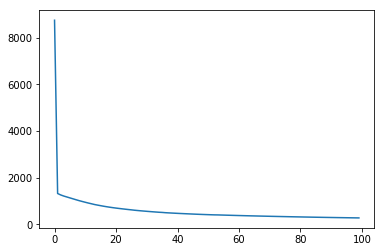

In [45]:
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.show()

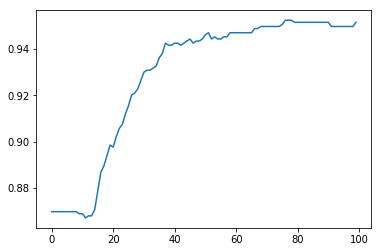

In [46]:
plt.plot(all_accuracies)
plt.show()

### testing

In [47]:
all_preds = []
dy.renew_cg()
for doc in test_docs:
    idxs = words2indexes(doc, w2i)
    ave_embedding = get_average_embedding(idxs)
    pred = forward_pass(ave_embedding)
    all_preds.append(pred.value())

Not surpisingly, the model now learns how to distinguish different documents, and so the predictions range all over.

In [48]:
print(all_preds[:100])

[0.6556558012962341, 0.00034403815516270697, 0.0006847633048892021, 0.00019579731451813132, 3.148395262542181e-05, 0.031864333897829056, 0.0002002134278882295, 7.159064261941239e-05, 0.0004632560012396425, 0.003368380945175886, 0.007158327382057905, 0.0035529446322470903, 0.00345473806373775, 0.9214901328086853, 0.002123923972249031, 0.007543424144387245, 0.0007220315746963024, 0.0031344410963356495, 0.9585365056991577, 2.2997510029654222e-07, 0.02617676556110382, 0.2993135452270508, 0.15958604216575623, 0.0015080824960023165, 0.0030091917142271996, 0.0005681368638761342, 0.0022377369459718466, 0.003977429121732712, 0.7797579169273376, 0.027505356818437576, 0.5282421708106995, 0.004104707855731249, 0.001457302481867373, 0.021853499114513397, 0.008700339123606682, 3.195796671207063e-05, 0.321938693523407, 0.00033812865149229765, 0.02617678977549076, 0.996843695640564, 0.5036551356315613, 0.006232960149645805, 0.0009685894474387169, 0.02478676475584507, 0.037448275834321976, 0.0002730213

And our accuracy is fantastic!

In [49]:
accuracy = get_accuracy([check_score(p, y) for p,y in zip(all_preds, list(test_labels))])
accuracy

0.9515260323159784